In [1]:
import os
os.chdir('/Users/corentin/Documents/M2/BIPODS/Project/iPMCMC/ipmcmc')
%run generate_data.py
%run linear_gaussian_state_model
%run smc.py
%run csmc.py
%run ipmcmc.py

In [2]:

# 4.1. Linear Gaussian State Space Model
from scipy.spatial.transform import Rotation as R
np.random.seed(420)

# Parameters
r = R.from_rotvec(np.array([7*np.pi/10, 3*np.pi/10, np.pi/20]))
rotation_matrix = r.as_dcm()
scaling_matrix = 0.99*np.eye(3)
beta = np.random.dirichlet(np.ones(20)*0.2, 3).transpose()
alpha = scaling_matrix@rotation_matrix
t_max = 50
mu = np.array([0, 1, 1])
start_var = 0.1*np.eye(3)
omega = np.eye(3)
sigma = 0.1*np.eye(20)


n_particles = 100

linear_transition_model = [LinearMu(default_mean=mu, default_cov=start_var)]+[LinearTransition(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(1, t_max)]
linear_proposals = [LinearMu(default_mean=mu, default_cov=start_var)]+[LinearProposal(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(1, t_max)]
linear_observation_model = [LinearObservation(default_mean=np.zeros(20),default_cov=sigma,default_beta=beta) for t in range(0, t_max)]


# If we want to change the parameters
assert np.all(np.linalg.eigvals(start_var) > 0)
assert np.all(np.linalg.eigvals(omega) > 0)
assert np.all(np.linalg.eigvals(sigma) > 0)

l_states, l_observations = linear_gaussian_state_space(t_max=t_max, mu=mu, start_var=start_var, transition_var=omega, noise_var=sigma, transition_coeffs=alpha, observation_coeffs=beta)
display((l_states.shape, l_observations.shape))

((50, 3), (50, 20))

In [8]:
n_nodes = 32
n_conditional_nodes = 16
n_steps = 100
init_conditional_traj = np.zeros((n_conditional_nodes, t_max, len(mu)))

for i in range(n_conditional_nodes):
    particles, _, _ = smc(l_observations, n_particles,
       linear_transition_model, linear_proposals, linear_observation_model)
    init_conditional_traj[i] = particles.mean(axis=1)

In [9]:
particles, conditional_traj, weights, conditional_indices, zetas = ipmcmc(
    n_steps, n_nodes, n_conditional_nodes, l_observations, n_particles, init_conditional_traj,
    linear_proposals, linear_transition_model, linear_observation_model)

In [21]:
zetas.shape

(5, 16, 32)

In [49]:
from filterpy.kalman import KalmanFilter

fk = KalmanFilter(dim_x=3, dim_z=20)

fk.x = mu
fk.P = start_var

fk.F = alpha
fk.Q = omega

fk.H = beta
fk.R = sigma

mu_kal, cov_kal, _, _ = fk.batch_filter(l_observations)
means, covs, gain, predicted_covs = fk.rts_smoother(mu_kal, cov_kal)

In [15]:
w_barre = weights.mean(axis=2)

rao_black_traj = np.zeros((n_steps, n_conditional_nodes, t_max, len(mu)))
for r in range(n_steps):
    for p in range(n_conditional_nodes):
        for m in range(n_nodes):
            weighted_sum_parts = np.zeros((t_max, len(mu)))
            for n in range(n_particles):
                weighted_sum_parts += w_barre[r, m, n] * particles[r, m, :, n]
            weighted_zetas = zetas[r, p, m] * weighted_sum_parts
            rao_black_traj[r, p] += weighted_zetas

estimated_means_from_ipmcmc = np.mean(rao_black_traj, axis=(0,1))

In [40]:
def computeError(rao_black_traj, ground_truth, mcmc_step=100, state_step=None):
    if state_step is None:
        estimated_mean = np.mean(rao_black_traj[0:mcmc_step], axis=(0,1))
        return np.mean((estimated_mean - ground_truth)**2)
    else:
        estimated_mean = np.mean(rao_black_traj[:,:,0:state_step], axis=(0,1))
        return np.mean((estimated_mean - ground_truth[0:state_step])**2)


In [50]:
errors_function_of_mcmc_step = []
errors_function_of_state_step = []
for r in range(1, (n_steps+1)):
    errors_function_of_mcmc_step.append(computeError(rao_black_traj, means, r))
    
for t in range(1, (t_max+1)):
    errors_function_of_state_step.append(computeError(rao_black_traj, means, state_step=t))

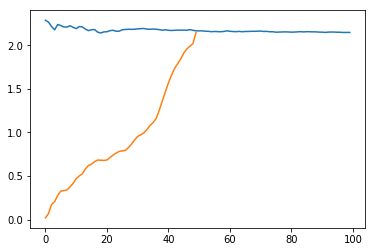

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(errors_function_of_mcmc_step)
plt.plot(errors_function_of_state_step)
plt.savefig('error.png')

In [52]:
errors_function_of_state_step


[0.019942060898254208,
 0.0689888042587977,
 0.17382803296240698,
 0.20706046399105923,
 0.2786403057265912,
 0.32728260076623245,
 0.332581304934841,
 0.3419124666990414,
 0.37522973649035773,
 0.4153713890848757,
 0.46841273424464186,
 0.5013741105404392,
 0.5240061914291281,
 0.5823685256713305,
 0.6216273483169731,
 0.6358330660067274,
 0.6650038119908835,
 0.6837521191017075,
 0.6818548791285468,
 0.6794533156351978,
 0.684601859896129,
 0.7123447429022152,
 0.739825677028845,
 0.7638850920674337,
 0.7824752847281655,
 0.7892111839794665,
 0.7941952939166121,
 0.8262470527346755,
 0.8652597360251526,
 0.9145554005775632,
 0.9553246133333004,
 0.973145645108322,
 0.9949154119145074,
 1.0319509230655963,
 1.0785080186037335,
 1.1126555084315282,
 1.1596462210033345,
 1.2514170268365776,
 1.3600354555012204,
 1.4643754576026173,
 1.5671666707493084,
 1.6557923891366535,
 1.734047052457613,
 1.7875192367311643,
 1.8433689940573783,
 1.9106730599771555,
 1.9576513193415201,
 1.98938857

In [72]:
import time

def build_unique_states(particles):
    unique_states = []
    n_steps, n_nodes, trajectories_length, n_particles, _ = particles.shape
    for t in range(trajectories_length):
        print(t)
        timet = time.time()
        unique_states.append([])
        for r in range(n_steps):
            for m in range(n_nodes):
                for n in range(n_particles):
                    particle_state = particles[r, m, t, n]
                    already_in = False
                    if len(np.unique(np.array(unique_states[t] + [particle_state]), axis=0)) != len(unique_states[t]):
                        unique_states[t].append(particle_state)
        #            for x in unique_states[t]:
        #                if (particle_state == x).all():
        #                   already_in = True
        #            if not already_in:
        #                unique_states[t].append(particle_state)
        print(time.time() - timet)
            
def compute_ess(particles, weights, rao_black_traj):
    return None

In [63]:
particles[:,:,0].shape

(100, 32, 100, 3)

In [73]:
unique_states = build_unique_states(particles)

0


UnboundLocalError: local variable 'time' referenced before assignment